In [10]:
using DelimitedFiles
using DataFrames
using DynamicAxisWarping
using Plots

push!(LOAD_PATH,"./src/")
using ExpEval

In [11]:
## For UCR archive information handeling
url="https://www.cs.ucr.edu/~eamonn/time_series_data_2018/DataSummary.csv"
DataSumary, DataSumary_header = readdlm(download(url), ',', header = true)
DataSumary_header[[1,4,5]] = ["ID", "Train", "Test"] # Original names "\ufeffID", "Train ", "Test "

DataSumary_df = DataFrame(DataSumary, vec(DataSumary_header))
println(size(DataSumary_df))
print(DataSumary_df[1:15,:])

(128, 12)
15×12 DataFrame
 Row │ ID   Type       Name                   Train  Test  Class  Length  ED (w=0)  DTW (learned_w)   DTW (w=100)  Default rate  Data donor/editor        
     │ Any  Any        Any                    Any    Any   Any    Any     Any       Any               Any          Any           Any                      
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1    Image      Adiac                  390    391   37     176     0.3887    0.3913 (3)        0.3964       0.9591        A. Jalba
   2 │ 2    Image      ArrowHead              36     175   3      251     0.2       0.2000 (0)        0.2971       0.6057        L. Ye & E. Keogh
   3 │ 3    Spectro    Beef                   30     30    5      470     0.3333    0.3333 (0)        0.3667       0.8           K. Kemsley &  A. Bagnall
   4 │ 4    Image      BeetleFly              20     20    2      512  

In [12]:
## THIS SHOULD BE IN UTILS

function relabelLabels(labels_old)
    # Take a vector of n labels from c clases (works for ints and strings) 
    # and maps it bijectivelly to 1,2,...,c
    # Example: [b,b,a,c,b] -> [2,2,1,3,2]
    
    classes = sort(unique(labels_old))
    labels = Array{Int, 1}(undef, length(labels_old))
    
    for i = 1:length(labels_old)
        for j = 1:length(classes)
            if labels_old[i] == classes[j]
                labels[i] = j
            end
        end
    end
    return labels
end

relabelLabels (generic function with 1 method)

In [13]:
# Load test dataset 
ID = 101
TEST, TEST_labels, TRAIN, TRAIN_labels = LoadDataBase(ID, DataSumary_df, true);

#labels = relabelLabels()

ID      : 101
Name    : Fungi
Length  : 201
Train   : 18
Test    : 186
Classes : 18
    Train Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
    Test  Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
---------------------------------------------------


In [61]:
function dtw_naive(x,y)
    I = length(x)
    J = length(y)
    
    δm = [(x[i] - y[j])^2 for i=1:I, j=1:J]
    C = zeros(I+1, J+1)
    
    φm = zeros(Int, I+1, J+1)
    φm[2:I+1,1] .= 2
    φm[1,2:J+1] .= 3
    
    for i = 2:I+1
        for j = 2:J+1
            C[i,j] = δm[i-1,j-1] + min(C[i-1, j-1], C[i-1, j], C[i, j-1])
            φm[i,j] = argmin([C[i-1, j-1], C[i-1, j], C[i, j-1]])
        end
    end
    
    i = I
    j = J
    πi = [i]
    πj = [j]
    while i>1 || j>1
        if φm[i+1,j+1] == 1
            i = i - 1
            j = j - 1
        elseif φm[i+1,j+1] == 2
            i = i - 1
        elseif φm[i+1,j+1] == 3
            j = j - 1
        else
            break
        end        
        append!(πi, i)
        append!(πj, j)
    end
    
    return C[I+1,J+1], reverse!(πi), reverse!(πj)
end

dtw_naive (generic function with 1 method)

C_1 = 1
C_8 = 2
dtw1 = 283.45602735552507
dtw2 = 280.28243932550714


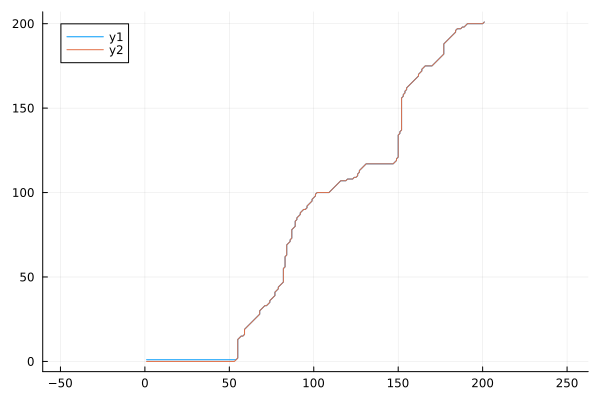

In [62]:
i = 1
j = 8

println("C_$i = ",TEST_labels[i],"\nC_$j = ",TEST_labels[j])


dtw1, i1, j1  = dtw(TEST[i,:], TEST[j,:])
dtw2, i2, j2  = dtw_naive(TEST[i,:], TEST[j,:])

println("dtw1 = $dtw1\ndtw2 = $dtw2")

plot(i1, j1, ratio=1)
plot!(i2, j2, ratio=1)

In [64]:
j2

303-element Vector{Int64}:
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   ⋮
 199
 200
 200
 200
 200
 200
 200
 200
 200
 200
 200
 201